
# MVP: *Machine Learning & Analytics*
**Autor:** RICARDO SIMPLICIO SIMPLICIO RODRIGUES DE LIMA  

**Data:** 28/09/2025

**Matrícula:** RA 4052024001247
**Turma:** 40530010006_20250_01

**Dataset:** Dataset kagle: Influenza in New York 2009-2018

https://www.kaggle.com/datasets/titustitus/h1n1-new-york-2009


---



## 1. Escopo, objetivo e definição do problema
O objetivo deste trabalho é criar um modelo preditivo, baseado em recursos de machine learning que seja capaz de estimar a quantidade infectados, tomando como base os dados do dataset Influenza in New York 2009-2018.


## 2. Reprodutibilidade e ambiente

Para a execução deste notebook, de forma a tribuir a capacidade de exeução em diferente momento, bem bom em diferente usuários e temrinais, principalmente necessário para a estabilidade quando se trabalha em série temporais.
Requere-se, desta forma, a contrução de um ambiente computacional baseado em Python no serão realizadas as seguintes tarefas:

*   Carregamento de dados;
*   Preprocessamento de dados;
*   Limpeza de dados;
*   Vizualização de Dados;
*   Cálculos matemáticos;
*   Treinamento de maquina supervisionado e não supervisionado para realização dde Modelos preditivos;
*   E avaliação de modelos.

Para isso serão baixadas as bibliotecas
*   OS;
*   Sys;
*   Math;
*   Random;
*   Time;
*   Numpy;
*   Pandas;
*   Scikit-learn;
*   Matplotlib;

Ainda neste contexto, é mantida o gerador de número aleatório que serão usados em diversas bibliotecas como o Numpy (np) e a Random, como *SEED*= 42, a mais popular.

In [ ]:
import os, random, time, sys, math
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score,
                             silhouette_score)

from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint, uniform

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Para frameworks que suportam seed adicional (ex.: PyTorch/TensorFlow), documente aqui:
# import torch; torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
# import tensorflow as tf; tf.random.set_seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)

Python: 3.12.11
Seed global: 42


### 2.2 Funções python (opcional)
Defina, se necessário, funções em Python para reutilizar seu código e torná-lo mais organizado. Essa é uma boa prática de programação que facilita a leitura, manutenção e evolução do seu projeto.

In [ ]:
def evaluate_classification(y_true, y_pred, proba=None):
    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    auc = roc_auc_score(y_true, proba[:,1]) if (proba is not None and proba.shape[1]==2) else np.nan
    return {"accuracy": acc, "f1_weighted": f1w, "roc_auc": auc}

def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def evaluate_clustering(X_original, model):
    # Silhouette requer >1 cluster e dados transformados
    try:
        if hasattr(model.named_steps["pre"], "transform"):
            X_emb = model.named_steps["pre"].fit_transform(X_original)  # cuidado: apenas para demo
        else:
            X_emb = X_original
        labels = model.named_steps["model"].fit_predict(X_emb)
        sil = silhouette_score(X_emb, labels)
        return {"silhouette": sil}
    except Exception as e:
        return {"silhouette": np.nan, "erro": str(e)}


## 3. Dados: carga, entendimento e qualidade

**SOBRE O CONJUNTO DE DADOS:**

No cenário da pandemia de COVID-19, dados sobre doenças semelhantes, como a influenza, tornam-se extremamente úteis para cientistas de dados. A cidade de Nova York foi uma das mais impactadas pela COVID-19, e compreender como ocorreram infecções em períodos anteriores pode ajudar tanto a prever novas ondas de disseminação quanto a desenvolver métodos de amostragem mais eficazes.
 descreva a origem dos dados, dicionário de variáveis e licença/ética quando aplicável.  

Este conjunto de dados reúne informações semanais de casos positivos de influenza nos condados de Nova York, cobrindo o período de outubro de 2009 a março de 2019.
Os meses contemplados na base são: janeiro, fevereiro, março, abril, maio, outubro, novembro e dezembro.

Neste conjunto de dados existem informações por condado (o que seria distritos municipais no Brasil) sobre: quantidade dde leitos hospitalalares , índice de desemprego, tamanho da população renda média, idade mediana, despesas anuais com intervenções  hospitalares.


In [ ]:
df = pd.read_csv("/content/Influenza_NY.csv")

df.head()

print("\033[1mATRIBUTOS DO DATASET:\033[0m")
for col in df.columns:
    print(col)



ATRIBUTOS DO DATASET:
Unnamed: 0
County
Year
Month
Season
Region
Week
Week Ending Date
Disease
Infected
Avg household size
Area
Population
Under_18
18-24
25-44
45-64
Above_65
Median_age
Medianfamilyincome
Number_households
Beds_adult_facility_care
Beds_hospital
County_Served_hospital
Service_hospital
Discharges_Other_Hospital_intervention
Discharges_Respiratory_system_interventions
Total_Charge_Other_Hospital_intervention
Total_Charge_Respiratory_system_interventions
Unemp_rate


In [ ]:

# === Verificações iniciais ===
print("\033[1mAMOSTRA DO DATASET\033[0m")
display(df.sample(5))
print("\nFormato:", df.shape)
print("\nTIPO DE VARIÁVEIS:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())

AMOSTRA DO DATASET


,Unnamed: 0,County,Year,Month,Season,Region,Week,Week Ending Date,Disease,Infected,...,Number_households,Beds_adult_facility_care,Beds_hospital,County_Served_hospital,Service_hospital,Discharges_Other_Hospital_intervention,Discharges_Respiratory_system_interventions,Total_Charge_Other_Hospital_intervention,Total_Charge_Respiratory_system_interventions,Unemp_rate
39875,39875,ROCKLAND,2012,3,2011-2012,METRO,11,03/17/2012,INFLUENZA_UNSPECIFIED,0,...,99242,1831.0,2174.0,153.0,226.0,30563.0,4190.0,1.028796e+09,2.314910e+08,7.4
45675,45675,ST LAWRENCE,2012,11,2012-2013,CENTRAL,44,11/03/2012,INFLUENZA_A,0,...,41605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.9
35062,35062,OTSEGO,2012,2,2011-2012,CAPITAL DISTRICT,7,02/18/2012,INFLUENZA_B,0,...,24620,230.0,617.0,130.0,40.0,11781.0,1448.0,2.022844e+08,2.410714e+07,9.5
3666,3666,CATTARAUGUS,2010,12,2010-2011,WESTERN,51,12/25/2010,INFLUENZA_A,0,...,32263,342.0,738.0,105.0,12.0,6501.0,1188.0,5.805184e+07,1.386492e+07,9.7
26503,26503,NASSAU,2013,1,2012-2013,METRO,1,01/05/2013,INFLUENZA_B,18,...,448528,4895.0,11643.0,2349.0,616.0,172124.0,20566.0,8.861269e+09,1.058791e+09,7.3



Formato: (57846, 30)

TIPO DE VARIÁVEIS:
Unnamed: 0                                         int64
County                                            object
Year                                               int64
Month                                              int64
Season                                            object
Region                                            object
Week                                               int64
Week Ending Date                                  object
Disease                                           object
Infected                                           int64
Avg household size                               float64
Area                                             float64
Population                                         int64
Under_18                                         float64
18-24                                            float64
25-44                                            float64
45-64                                         

### TRATAMENTO DE MISSINGS


É apresentados a situação dde integridade do dados, principalmente quando se trata dde dados ausentes.
Neste sentido são apresnetados a situação atual dos dados (dataframe: DF) e a situação em que o conjunto de dados de se tornou quando foram retiradas algumas linhas nas quais em alguma coluna havia dados ausentes, chamadno por tanto do dataframe como df_sem_os_nulos.


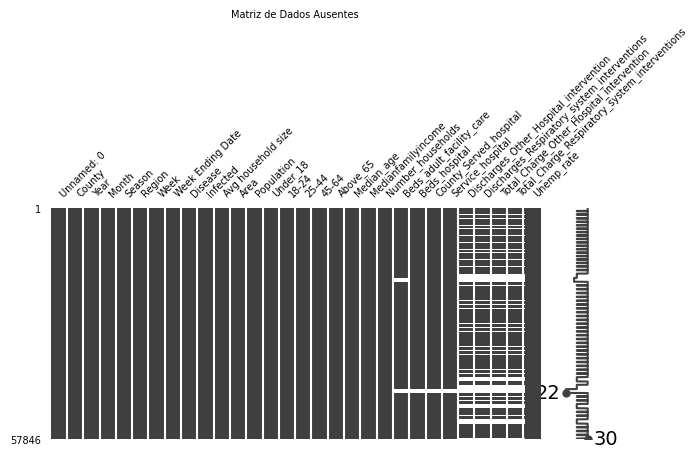

In [ ]:

#Apresetando a matrix com  a verificação gráficas e vazios nas linhas e colunas
import missingno as ms
ms.matrix(df, figsize=(7, 3))
plt.title('Matriz de Dados Ausentes', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

Antes: 57846 linhas
Depois: 44196 linhas


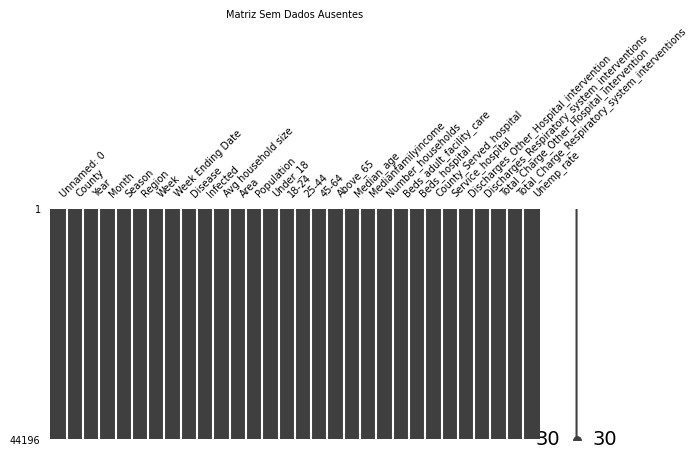

In [ ]:

df_sem_nulos = df.dropna()

print(f"Antes: {df.shape[0]} linhas")
print(f"Depois: {df_sem_nulos.shape[0]} linhas")
ms.matrix(df_sem_nulos, figsize=(7, 3))
plt.title('Matriz Sem Dados Ausentes', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()



### 3.1 Análise exploratória resumida (EDA)
Esta análise exploratória de dados sucinta são verificadas a ausencia de dados nos mês de junho a setembro, apesar de coinncidente com o verão novaiorquino, pode tabém ser fruto do o tratamento de dados ausentes realizados no iten anterior.

   Month  quantidade_notificacoes  media_mensal
0      1                   5688.0         12.11
1      2                   5076.0         11.87
2      3                   5571.0          9.56
3      4                   5577.0          6.56
4      5                   4098.0          1.77
5     10                   5748.0          1.25
6     11                   6030.0          2.68
7     12                   6408.0          5.99
8  Média                   5524.5          6.47


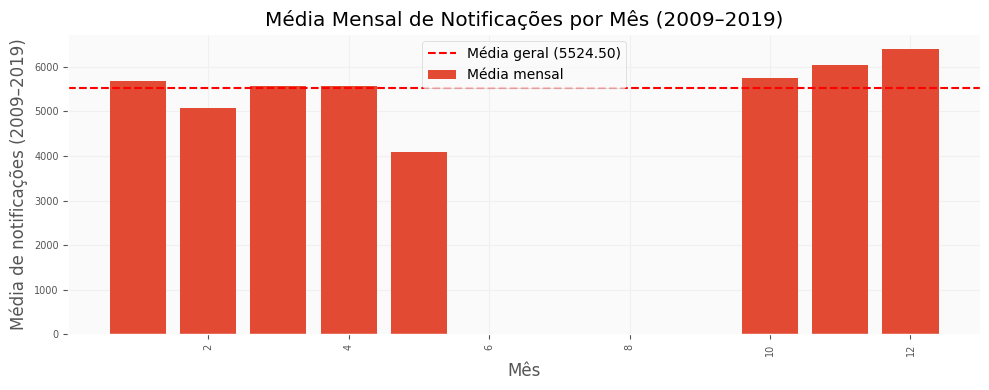

In [ ]:
#Tabela síntese de dados total por mês e média mensal

notificacoes_mes = (df_sem_nulos.groupby('Month', as_index=False)['Infected'].count().rename(columns={'Infected': 'quantidade_notificacoes'})).round(2)
media_mensal = (df_sem_nulos.groupby('Month', as_index=False)['Infected'].mean().rename(columns={'Infected': 'media_mensal'})).round(2)
tabela = notificacoes_mes.merge(media_mensal, on='Month')
linha_media = pd.DataFrame({
    'Month': ['Média'],
    'quantidade_notificacoes': [tabela['quantidade_notificacoes'].mean().round(2)],
    'media_mensal': [tabela['media_mensal'].mean().round(2)]})

tabela = pd.concat([tabela, linha_media], ignore_index=True)
print(tabela)

#Gráfico
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rc("axes", facecolor="#fafafa", grid=True)
plt.rc("grid", color="#f0f0f0")

plt.figure(figsize=(10, 4))
plt.bar(notificacoes_mes['Month'], notificacoes_mes['quantidade_notificacoes'], label='Média mensal')

plt.axhline(y=media_notificacoes_por_mes, linestyle='--', color='red',
            label=f'Média geral ({media_notificacoes_por_mes:.2f})')

plt.xlabel('Mês')
plt.ylabel('Média de notificações (2009–2019)')
plt.title('Média Mensal de Notificações por Mês (2009–2019)')
plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=7)
plt.legend()
plt.tight_layout()
plt.show()


## 4. Preparação de dados para Treino


In [ ]:
# Carga do dataset

# Create a copy of df_sem_nulos and add the 'Month' column as target
dataset = df_sem_nulos.copy()
dataset['target'] = dataset['Infected']
dataset.head()

,Unnamed: 0,County,Year,Month,Season,Region,Week,Week Ending Date,Disease,Infected,...,Beds_adult_facility_care,Beds_hospital,County_Served_hospital,Service_hospital,Discharges_Other_Hospital_intervention,Discharges_Respiratory_system_interventions,Total_Charge_Other_Hospital_intervention,Total_Charge_Respiratory_system_interventions,Unemp_rate,target
0,0,ALBANY,2009,10,2009-2010,CAPITAL DISTRICT,40,10/10/2009,INFLUENZA_A,4,...,1214.0,3258.0,285.0,297.0,57336.0,5313.0,1.706730e+09,136888439.0,6.9,4
1,1,ALBANY,2009,10,2009-2010,CAPITAL DISTRICT,40,10/10/2009,INFLUENZA_B,0,...,1214.0,3258.0,285.0,297.0,57336.0,5313.0,1.706730e+09,136888439.0,6.9,0
2,2,ALBANY,2009,10,2009-2010,CAPITAL DISTRICT,40,10/10/2009,INFLUENZA_UNSPECIFIED,0,...,1214.0,3258.0,285.0,297.0,57336.0,5313.0,1.706730e+09,136888439.0,6.9,0
3,3,ALBANY,2009,10,2009-2010,CAPITAL DISTRICT,41,10/17/2009,INFLUENZA_A,11,...,1214.0,3258.0,285.0,297.0,57336.0,5313.0,1.706730e+09,136888439.0,6.9,11
4,4,ALBANY,2009,10,2009-2010,CAPITAL DISTRICT,41,10/17/2009,INFLUENZA_B,0,...,1214.0,3258.0,285.0,297.0,57336.0,5313.0,1.706730e+09,136888439.0,6.9,0


## 5. Treino, Teste e Acurácia do Modelo

Aqui foi necessário, se alterar o  modo do split, optanto por preservar a ordem temporal visando obter o melhor resultados, da mesma usando o TimeSeriesSplit para não emberalhar e preservando o vazamento de dados no modelo. O uso do train_test_split não trouxe inicialmente bons resultados de acurário para o modelo.

In [ ]:
# === Split temporal ===
df_ = dataset.copy()

# 1) Ordena temporalmente
date_cols = [c for c in ['timestamp', 'Date', 'Data'] if c in df_.columns]
if date_cols:
    dcol = date_cols[0]
    df_[dcol] = pd.to_datetime(df_[dcol], errors='coerce')
    df_ = df_.sort_values(dcol)
elif {'Year', 'Month'}.issubset(df_.columns):
    # Data sintética a partir de Year/Month
    if df_['Month'].dtype == 'O':
        map_m = {
            'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12,
            'Jan.':1,'Feb.':2,'Mar.':3,'Apr.':4,'May.':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12,
            'Fev':2,'Abr':4,'Mai':5,'Ago':8,'Set':9,'Out':10,'Dez':12
        }
        df_['MonthNum'] = df_['Month'].map(map_m).fillna(pd.to_numeric(df_['Month'], errors='coerce'))
    else:
        df_['MonthNum'] = pd.to_numeric(df_['Month'], errors='coerce')
    df_['__date__'] = pd.to_datetime(
        dict(year=df_['Year'].astype(int), month=df_['MonthNum'].astype(int), day=1),
        errors='coerce'
    )
    df_ = df_.sort_values('__date__')
else:
    # Ordena pelo índice, como último recurso
    df_ = df_.sort_index()

# 2) Define X e y (evita vazamento do alvo)
y = df_['target'].astype(float)
X = df_.drop(columns=['target', 'Infected'], errors='ignore')  # <— remove também 'Infected'

# 3) Mantém somente numéricas (se quiser usar categóricas, trate com OneHot no Pipeline)
X = X.select_dtypes(include='number')

# 4) Corte temporal 80/20 (sem embaralhar)
cutoff = int(len(X) * 0.8)
X_train, X_test = X.iloc[:cutoff].copy(), X.iloc[cutoff:].copy()
y_train, y_test = y.iloc[:cutoff].copy(), y.iloc[cutoff:].copy()
print("Treino:", X_train.shape, "| Teste:", X_test.shape)

# 5) Validação cruzada temporal
from sklearn.model_selection import TimeSeriesSplit
n_splits = min(5, max(2, len(X_train)//3))  # evita n_splits > n_samples
tscv = TimeSeriesSplit(n_splits=n_splits)
print(f"TimeSeriesSplit com n_splits={n_splits}")

Treino: (35356, 25) | Teste: (8840, 25)
TimeSeriesSplit com n_splits=5


## Modelagem de Dados

LR: MSE 832.11 (519.28) - RMSE 28.85
Ridge: MSE 831.55 (519.24) - RMSE 28.84
Lasso: MSE 830.01 (518.83) - RMSE 28.81
KNN: MSE 802.16 (537.94) - RMSE 28.32
CART: MSE 1127.69 (869.54) - RMSE 33.58
SVR: MSE 846.96 (600.18) - RMSE 29.10


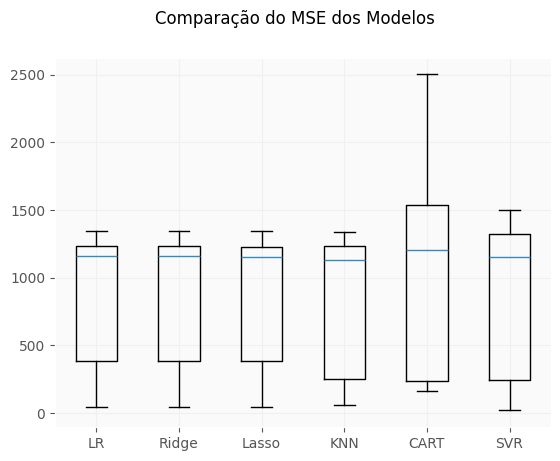

In [ ]:
# Modelagem
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(7)

# Detecta colunas numéricas e categóricas no X_train
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category','bool']).columns.tolist()

# Pré-processamento: imputação + (escala para numéricos) + One-Hot nas categóricas
preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imp', SimpleImputer(strategy='median')),
            ('sc', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline([
            ('imp', SimpleImputer(strategy='most_frequent')),
            ('oh', OneHotEncoder(handle_unknown='ignore')
        )]), cat_cols)
    ],
    remainder='drop'
)

# Pipelines de modelos (todos recebem o mesmo preprocess)
models = [
    ('LR',    Pipeline([('prep', preprocess), ('model', LinearRegression())])),
    ('Ridge', Pipeline([('prep', preprocess), ('model', Ridge(alpha=1.0, random_state=7))])),
    ('Lasso', Pipeline([('prep', preprocess), ('model', Lasso(alpha=0.001, random_state=7))])),
    ('KNN',   Pipeline([('prep', preprocess), ('model', KNeighborsRegressor())])),
    ('CART',  Pipeline([('prep', preprocess), ('model', DecisionTreeRegressor(random_state=7))])),
    ('SVR',   Pipeline([('prep', preprocess), ('model', SVR())]))
]

# Avaliação
results, names = [], []
for name, model in models:
    scores = cross_val_score(model, X_train, y_train,
                         cv=tscv, scoring='neg_mean_squared_error')
    mse_mean = -scores.mean()
    mse_std  = scores.std()
    rmse     = np.sqrt(mse_mean)
    results.append(-scores)   # para boxplot positivo
    names.append(name)
    print(f"{name}: MSE {mse_mean:.2f} ({mse_std:.2f}) - RMSE {rmse:.2f}")

# Gráfico
plt.figure()
plt.suptitle('Comparação do MSE dos Modelos')
plt.boxplot(results)
plt.xticks(range(1, len(names)+1), names)
plt.show()

## Avaliação e Diagnóstico do Medelo

Será avaliado o desempenho do modelo n o connjunto de test, avaliando RMSE, MAE, R², MAPE/sMAPE e NRMSE, comparação de baseline e diagnósticos de erros.

   model    RMSE     MAE     R2  NRMSE_mean  NRMSE_std          MAPE    sMAPE
2  Lasso  34.397  12.005  0.123       3.621      0.937  3.199411e+11  153.961
1  Ridge  34.413  12.023  0.122       3.623      0.937  3.197762e+11  154.243
0     LR  34.418  12.030  0.122       3.624      0.937  3.199141e+11  154.310
5    SVR  36.994   9.229 -0.015       3.895      1.007  2.110338e+10  181.138
3    KNN  37.055  10.911 -0.018       3.901      1.009  1.841900e+11  111.756
4   CART  40.768  14.389 -0.232       4.292      1.110  3.566063e+11  109.577

Baseline naive (t-1) RMSE: 50.03
Baseline sazonal-12 RMSE: 50.30

Melhor modelo: Lasso | RMSE=34.40
Skill vs naive:  0.312
Skill vs saz-12: 0.316


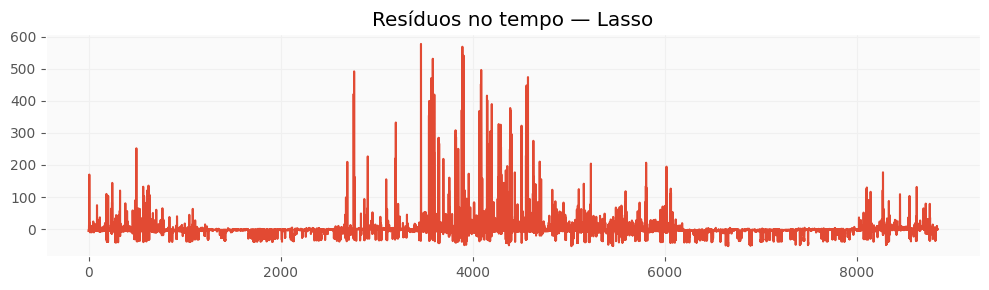

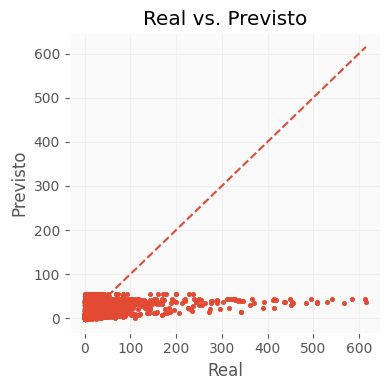

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def eval_holdout(name, pipe, X_tr, y_tr, X_te, y_te):
    pipe.fit(X_tr, y_tr)
    y_hat = pipe.predict(X_te)
    mse = mean_squared_error(y_te, y_hat) # Removendo squared=False
    rmse = np.sqrt(mse) # Calculando "manualmente" RMSE
    mae  = mean_absolute_error(y_te, y_hat)
    r2   = r2_score(y_te, y_hat)
    nrmse_mean = rmse / (np.mean(np.abs(y_te)) + 1e-9)
    nrmse_std  = rmse / (np.std(y_te) + 1e-9)
    mape  = (np.abs((y_te - y_hat) / np.maximum(np.abs(y_te), 1e-9))).mean()*100
    smape = (2*np.abs(y_hat - y_te)/(np.abs(y_te)+np.abs(y_hat)+1e-9)).mean()*100
    return dict(model=name, RMSE=rmse, MAE=mae, R2=r2,
                NRMSE_mean=nrmse_mean, NRMSE_std=nrmse_std,
                MAPE=mape, sMAPE=smape, y_hat=y_hat)

#Todos os modelos avaliados em hold-out
rows = []
preds = {}
for name, pipe in models:
    m = eval_holdout(name, pipe, X_train, y_train, X_test, y_test)
    preds[name] = m.pop('y_hat')
    rows.append(m)
holdout_df = pd.DataFrame(rows).sort_values('RMSE')
print(holdout_df.round(3))

#Baselines (ingênuo t-1 e sazonal-12)
y_all = pd.concat([pd.Series(y_train).reset_index(drop=True),
                   pd.Series(y_test).reset_index(drop=True)], ignore_index=True)

y_naive   = y_all.shift(1).iloc[-len(y_test):]
rmse_nv   = np.sqrt(mean_squared_error(y_test, y_naive)) # Removendo squared=False

rmse_seas = None
if len(y_all) >= len(y_test)+12:
    y_seas12 = y_all.shift(12).iloc[-len(y_test):]
    rmse_seas = np.sqrt(mean_squared_error(y_test, y_seas12)) # Removendo squared=False

print(f"\nBaseline naive (t-1) RMSE: {rmse_nv:.2f}")
if rmse_seas is not None:
    print(f"Baseline sazonal-12 RMSE: {rmse_seas:.2f}")

# score (quanto o modelo melhora vs. baseline)
best_row = holdout_df.iloc[0]
rmse_best = best_row['RMSE']
print(f"\nMelhor modelo: {best_row['model']} | RMSE={rmse_best:.2f}")
print(f"Skill vs naive:  {1 - rmse_best/(rmse_nv+1e-9):.3f}")
if rmse_seas is not None:
    print(f"Skill vs saz-12: {1 - rmse_best/(rmse_seas+1e-9):.3f}")

# 4) Diagnóstico rápido (resíduos do melhor)
y_hat_best = preds[best_row['model']]
res = y_test - y_hat_best

plt.figure(figsize=(10,3))
plt.plot(res.values)
plt.title(f"Resíduos no tempo — {best_row['model']}")
plt.tight_layout(); plt.show()

plt.figure(figsize=(4,4))
plt.scatter(y_test, y_hat_best, s=10)
mn, mx = min(y_test.min(), y_hat_best.min()), max(y_test.max(), y_hat_best.max())
plt.plot([mn,mx],[mn,mx],'--')
plt.xlabel('Real'); plt.ylabel('Previsto'); plt.title('Real vs. Previsto')
plt.tight_layout(); plt.show()


## 12. Conclusões e próximos passos
Apesar de todo um esforço para melhorar a precisão do modelos, abordadagem ainda não se apreswntou satisfatória,tendo em vista toda complexidade da séria temporal abordada por recursos preditivos lineares. Certamente é válido a criação deste modelo com uma abordagem com recursos que possibilitem resolver problemas não lineares visando melhores resultados.
O conjunto de dados se apresentou inicialmente mes simples, entretanto os resultados inicialmente apresentados revelou mais complexa , quando via-se o interesse que realizar a previsão de utilizando as variáveis numéricas.
Certamente o fato ser existe muito variavel nomérica  não representava correções com as variáveis mensais, o que levou a contribuir ocm os baixo resultados.

Como lição aprendida, nota-se a necessidade da compreenção mais profundação das feature na constituição do modelo, oujseja, certamente a abordagem també estaria em um esforço adicional nas variavel e não somente em refirnar a fase de treino e modelagem buscando melhores resultados.
